# Exploratory Data Analysis and Topic Modeling

This section will cover:

* initial exploratory analysis
* grammar and spelling correction 
* feature extraction with SpaCy 
* topic modeling with latent Dirichlet allocation (LDA).
* automatic scoring with LDA

In [1]:
#essential imports
%matplotlib inline

import numpy as np
import pandas as pd
import re
from datetime import datetime

In [2]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
#Text Processing Libraries
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation


In [4]:
#ML Libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split

import joblib

In [5]:
#LDA Visualization
import pyLDAvis.lda_model
from pyLDAvis.lda_model import prepare

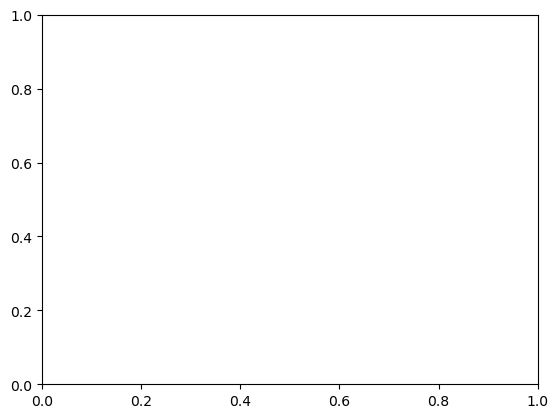

In [6]:
#matplotlib and pandas config
import seaborn as sns
#plt.style.use('seaborn-colorblind')
palette = sns.color_palette("colorblind")
plt.gca().set_prop_cycle('color', palette)
    
# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_colwidth', 100)

pyLDAvis.enable_notebook()
# plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [7]:
training_set  = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})
training_set.sample()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,rater1_trait1,rater1_trait2,rater1_trait3,rater1_trait4,rater1_trait5,rater1_trait6,rater2_trait1,rater2_trait2,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
10409,16359,6,The Mooring Mast has two obstacles @CAPS1 the winds on top of the building are constantly shifti...,2,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12976 non-null  int64  
 1   topic           12976 non-null  int64  
 2   essay           12976 non-null  object 
 3   rater1_domain1  12976 non-null  int64  
 4   rater2_domain1  12976 non-null  int64  
 5   rater3_domain1  128 non-null    float64
 6   target_score    12976 non-null  int64  
 7   rater1_domain2  1800 non-null   float64
 8   rater2_domain2  1800 non-null   float64
 9   topic2_target   1800 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

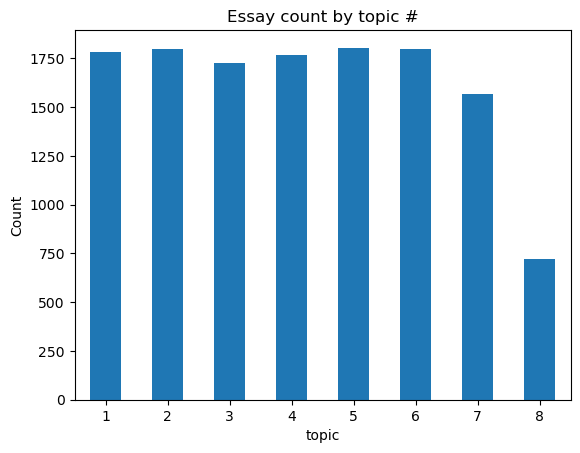

In [9]:
training_set.groupby('topic').agg('count').plot.bar(y='essay', rot=0, legend=False)
plt.title('Essay count by topic #')
plt.ylabel('Count')
plt.show()

Since topic 8 has the fewest essays and the most distinct scores, it might prove to be the most challenging topic to model.

In [10]:
# Count characters and words for each essay
training_set['word_count'] = training_set['essay'].str.strip().str.split().str.len()

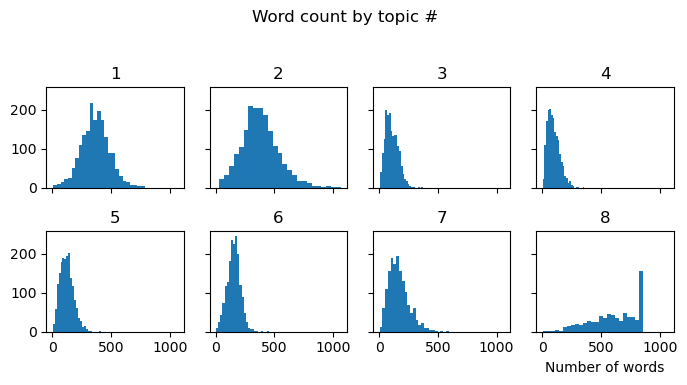

In [11]:
training_set.hist(column='word_count', by='topic', bins=25, sharey=True, sharex=True, layout=(2, 4), figsize=(7,4), rot=0) 
plt.suptitle('Word count by topic #')
plt.xlabel('Number of words')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [12]:
training_set.groupby(['topic'])['target_score'].agg(['min','max','count','nunique'])

,min,max,count,nunique
topic,,,,
1,2,12,1783,11
2,1,6,1800,6
3,0,3,1726,4
4,0,3,1770,4
5,0,4,1805,5
6,0,4,1800,5
7,2,24,1569,23
8,10,60,723,34


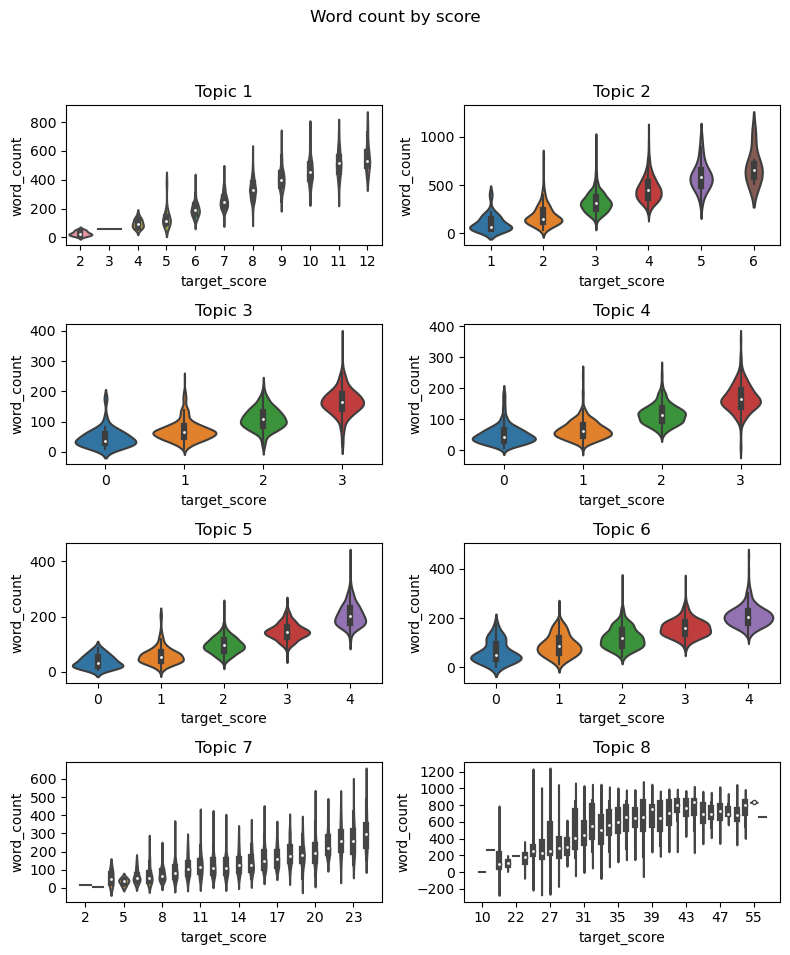

In [13]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(8,10))
for i in range(4):
    for j in range(2):
        topic_number += 1
        sns.violinplot(x='target_score', y='word_count', data=training_set[training_set['topic'] == topic_number], ax=ax[i,j])
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Word count by score')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We can see a reasonable correlation between word count and score for all but topic 8 where the word count apparently reaches a maximum at the upper third of the scores.

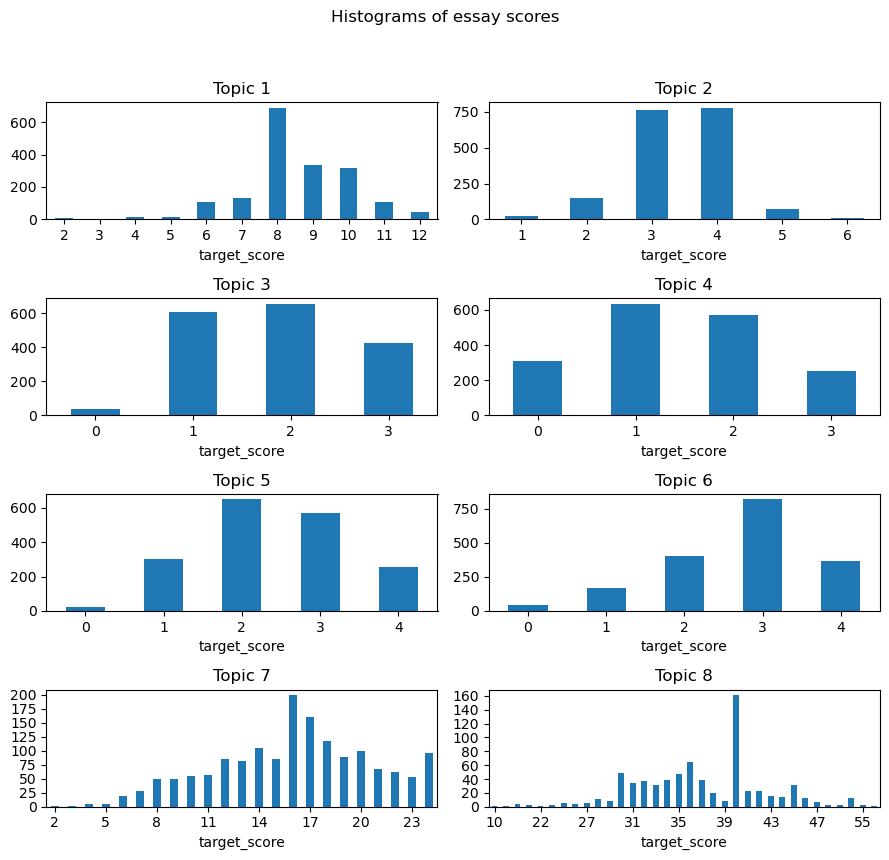

In [14]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(9,9), sharey=False)
for i in range(4):
    for j in range(2):
        topic_number += 1
        training_set[training_set['topic'] == topic_number]\
            .groupby('target_score')['essay_id']\
            .agg('count')\
            .plot.bar(ax=ax[i, j], rot=0)
        ax[i,j].set_title('Topic %i' % topic_number)
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.suptitle('Histograms of essay scores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Many scores are underrepresented. Classification could be difficult without rebalancing.

## Essay processing:

1. Language correction with languagetool (add number of corrections as feature)
2. Sentence tokenization with Spacy
3. Sentence count and length
4. Word tokenize with Spacy
5. Word token classification (punctuation, stop words and anonymized entities, pos, ent)
6. Document similarity (based on arbitrary high scoring essay for each topic)

## Grammar and spelling

As to be expected with student essays, many essays exhibit grammar and spelling errors. Therefore, the essays will be corrected using languagetool and the nlp parsing will be performed with Spacy on the corrected essays.

In [15]:
text = 'Some people are still using Myspoce instead of facdbook'

Textblob is an open source nlp package. Unlike Spacy, textblob includes a statistics based spell checker. 

https://textblob.readthedocs.io/en/dev/

In [16]:
from textblob import TextBlob
data = TextBlob(text)
print (data.correct())

Some people are still using Myspoce instead of facdbook


Languagetool.org has a python wrapper for spelling and grammatical errors at 
https://pypi.org/project/language-tool-python/

It appears to work quite well.

In [17]:
import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

matches = tool.check(text)
tool.correct(text)

'Some people are still using MySpace instead of Facebook'

In [18]:
text = training_set.essay[1871]
text

'I do think that there should be a censorship in not just in libaries, but everywhare.       Personlly, I think that the way that the libraries have the books are appropite and if the parents do not want thier children going any where  that is not privy to them keep a hand lenght away     As for the parents, the parents know the aera that intrest them ,therefor the parents should go there'

In [19]:
matches = tool.check(text)
tool.correct(text)


'I do think that there should be a censorship in not just in libraries, but everywhere.  Personally, I think that the way that the libraries have the books are appropriate and if the parents do not want their children going anywhere that is not privy to them keep a hand length away As for the parents, the parents know the area that interest them, therefor the parents should go there'

As seen in the last sentence, languagetool did not correct `",therefor"`. Nonetheless, it should be good enough to proceed.

In [20]:
"""
use language tool to correct for most spelling and grammatical errors. Also count the applied corrections. 
Using language_check python wrapper for languagetool:
https://pypi.org/project/language-tool-python/
"""
tool = language_tool_python.LanguageTool('en-US')

t0 = datetime.now()

training_set['matches'] = training_set['essay'].apply(lambda txt: tool.check(txt))
training_set['corrections'] = training_set.apply(lambda l: len(l['matches']), axis=1)
training_set['corrected'] = training_set.apply(lambda l: tool.correct(l['essay']), axis=1)

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

# save work
training_set.to_pickle('training_corr.pkl')

Processing time: 0:27:42.024892


Here's a very special example of poor writing skills (or perhaps a digitization error?). None of the spell checkers I tried were able to make much sense out of this.

In [21]:
print('Original:')
print(training_set.essay[18])
print('Corrected with languagetool:')
print(training_set.corrected[18])

Original:
I aegre waf the evansmant ov tnachnolage. The evansmant ov tnachnolige is being to halp fined a kohar froi alnsas. Tnanchnolage waf ont ot we wod not go to the moon. Tnachnologe evans as we maech at. The people are in tnacholege to the frchr fror the good ov live. Famas invanyor ues tnacholage leki lena orde dvanse and his fling mashine. Tnachologe is the grat
Corrected with languagetool:
I Segre weigh the Evanston of tnachnolage. The Evanston of tnachnolige is being to half fined a Zohar from Kansas. Tnanchnolage weigh on tot we won not go to the moon. Technology Evans as we match at. The people are in tnacholege to the arch for the good of live. FAMAS inventor UES anchorage Levi Lena order dance and his fling machine. Tnachologe is the great


## NLP with SpaCy

Although much of the analysis could be performed with other NLP packages, SpaCy was chosen due to its combination of speed and simplicity.

In [22]:
training_set = pd.read_pickle('training_corr.pkl')

In [23]:
sents = []
tokens = []
lemma = []
pos = []
ner = []

stop_words = set(STOP_WORDS)
stop_words.update(punctuation) # remove it if you need punctuation 

nlp = spacy.load('en_core_web_sm')

t0 = datetime.now()

# suppress numpy warnings
#np.warnings.filterwarnings('ignore')

for essay in nlp.pipe(training_set['corrected'], batch_size=100):
    if essay.is_parsed:
        tokens.append([e.text for e in essay])
        sents.append([sent.text.strip() for sent in essay.sents])
        pos.append([e.pos_ for e in essay])
        ner.append([e.text for e in essay.ents])
        lemma.append([n.lemma_ for n in essay])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)
        sents.append(None)
        ner.append(None)

training_set['tokens'] = tokens
training_set['lemma'] = lemma
training_set['pos'] = pos
training_set['sents'] = sents
training_set['ner'] = ner

t1 = datetime.now()
print('Processing time: {}'.format(t1 - t0))

/opt/anaconda3/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.0.0) was trained with spaCy v3.0.0 and may not be 100% compatible with the current version (3.7.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Processing time: 0:04:38.625142


In [24]:
training_set.to_pickle('training_spacy.pkl')

In [25]:
training_set = pd.read_pickle('training_spacy.pkl')

In [26]:
training_set[['tokens', 'pos', 'sents', 'ner']].head()

,tokens,pos,sents,ner
0,"[Dear, local, newspaper, ,, I, think, effects, computers, have, on, people, are, great, learning...","[ADJ, ADJ, NOUN, PUNCT, PRON, VERB, NOUN, NOUN, VERB, ADP, NOUN, AUX, ADJ, NOUN, NOUN, SYM, NOUN...","[Dear local newspaper, I think effects computers have on people are great learning skills/affect...","[@ORGANIZATION2, @CAPS1, @DATE1, @CAPS2]"
1,"[Dear, @CAPS1, @CAPS2, ,, I, believe, that, using, computers, will, benefit, us, in, many, ways,...","[PROPN, PROPN, PROPN, PUNCT, PRON, VERB, SCONJ, VERB, NOUN, AUX, VERB, PRON, ADP, ADJ, NOUN, ADP...","[Dear @CAPS1 @CAPS2, I believe that using computers will benefit us in many ways like talking an...","[Dear @CAPS1 @CAPS2, millions, one, millions, @LOCATION3, @LOCATION2, Million, @NUM1 hours, a lo..."
2,"[Dear, ,, @CAPS1, @CAPS2, @CAPS3, More, and, more, people, use, computers, ,, but, not, everyone...","[ADJ, PUNCT, PROPN, PROPN, PROPN, ADJ, CCONJ, ADJ, NOUN, VERB, NOUN, PUNCT, CCONJ, PART, PRON, V...","[Dear, @CAPS1 @CAPS2 @CAPS3 More and more people use computers, but not everyone agrees that thi...","[today, @CAPS4, a thousand]"
3,"[Dear, Local, Newspaper, ,, @CAPS1, I, have, found, that, many, experts, say, that, computers, d...","[PROPN, PROPN, PROPN, PUNCT, PROPN, PRON, AUX, VERB, SCONJ, ADJ, NOUN, VERB, SCONJ, NOUN, AUX, P...","[Dear Local Newspaper, @CAPS1 I have found that many experts say that computers do not benefit o...","[Dear Local Newspaper, @PERSON1, @PERCENT2, @PERCENT3, @PERCENT2, A+, @CAPS7, Newspaper, Newspap..."
4,"[Dear, @LOCATION1, ,, I, know, having, computers, has, a, positive, effect, on, people, ., The, ...","[ADJ, PROPN, PUNCT, PRON, VERB, VERB, NOUN, VERB, DET, ADJ, NOUN, ADP, NOUN, PUNCT, DET, NOUN, V...","[Dear @LOCATION1, I know having computers has a positive effect on people., The computers connec...","[First, @NUM1 hours, one, Secondly, one, only one, @CAPS1]"


# Topic Modeling with Latent Dirichlet Allocation

Latent Dirichlet Allocation, or **LDA**, uses probabilities to allocate any number of documents to a pre-defined number of topics. A very good explanation is given here:

https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/

In [27]:
# Replace topic numbers with meaningful one-word summary:
topic_dict = {'topic':{1: 'computer', 
                       2: 'censorship', 
                       3: 'cyclist', 
                       4: 'hibiscus', 
                       5: 'mood', 
                       6: 'dirigibles', 
                       7: 'patience', 
                       8: 'laughter'}}

training_set.replace(topic_dict, inplace=True)

# Lemmatized essays re-joined (list to essay)
training_set['l_essay'] = training_set['lemma'].apply(' '.join)

Convert essays to a matrix of token (lemma) counts:

In [31]:
# Baseline: number of unique lemma
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words=list(STOP_WORDS), 
                             max_features=2000) # default: binary=False
doc_term_matrix = vectorizer.fit_transform(training_set.l_essay) # using lemmatized essays

# Most frequent tokens:
words = vectorizer.get_feature_names_out()
doc_term_matrix_df = pd.DataFrame(doc_term_matrix.toarray(), columns=words)
word_freq = doc_term_matrix_df.sum(axis=0).astype(int)
word_freq.sort_values(ascending=False).head(10) 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


computer     20385
book         13976
building      7837
library       7631
dirigible     6250
read          6127
child         5767
help          5169
offensive     5117
talk          4981
dtype: int64

Apply LDA on the word frequency matrix.

In [32]:
lda_base = LatentDirichletAllocation(n_components=8,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     max_iter=40,
                                     perp_tol=0.01,
                                     verbose=1,
                                     evaluate_every=5)
lda_base.fit(doc_term_matrix)

# save base model
joblib.dump(lda_base, 'lda_baseline.pkl')

iteration: 1 of max_iter: 40
iteration: 2 of max_iter: 40
iteration: 3 of max_iter: 40
iteration: 4 of max_iter: 40
iteration: 5 of max_iter: 40, perplexity: 377.7940
iteration: 6 of max_iter: 40
iteration: 7 of max_iter: 40
iteration: 8 of max_iter: 40
iteration: 9 of max_iter: 40
iteration: 10 of max_iter: 40, perplexity: 375.1996
iteration: 11 of max_iter: 40
iteration: 12 of max_iter: 40
iteration: 13 of max_iter: 40
iteration: 14 of max_iter: 40
iteration: 15 of max_iter: 40, perplexity: 374.8480
iteration: 16 of max_iter: 40
iteration: 17 of max_iter: 40
iteration: 18 of max_iter: 40
iteration: 19 of max_iter: 40
iteration: 20 of max_iter: 40, perplexity: 374.7384
iteration: 21 of max_iter: 40
iteration: 22 of max_iter: 40
iteration: 23 of max_iter: 40
iteration: 24 of max_iter: 40
iteration: 25 of max_iter: 40, perplexity: 374.6739
iteration: 26 of max_iter: 40
iteration: 27 of max_iter: 40
iteration: 28 of max_iter: 40
iteration: 29 of max_iter: 40
iteration: 30 of max_iter: 40

['lda_baseline.pkl']

Topic probabilities for all words. The numbered topics are generated from the latent Dirichlet allocation. 

In [33]:
topic_labels = ['Topic {}'.format(i) for i in range(1, 9)]
topics_count = lda_base.components_
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.sample(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
grocery,0.000002,3.566629e-05,0.000001,1.010732e-04,0.000002,1.257325e-04,0.000001,0.000302
police,0.000002,3.451077e-05,0.000001,7.776651e-07,0.000002,2.157998e-04,0.000001,0.000302
increase,0.001493,6.085201e-05,0.000079,7.780401e-07,0.000388,6.794965e-04,0.000001,0.000003
luckily,0.000002,6.669756e-07,0.000014,2.208253e-04,0.000171,1.546135e-05,0.000001,0.000319
view,0.000375,3.671822e-03,0.000001,8.634331e-05,0.000465,2.554657e-04,0.000065,0.000003
network,0.000236,3.106371e-05,0.000020,7.771717e-07,0.000002,3.937072e-04,0.000001,0.000003
dangle,0.000002,6.663237e-07,0.002127,7.771105e-07,0.000002,9.935113e-07,0.000001,0.000003
box,0.000233,2.573980e-05,0.000001,5.207573e-04,0.000002,1.149679e-04,0.000001,0.000235
personality,0.000002,1.358855e-04,0.000001,2.775626e-04,0.000002,4.071248e-05,0.000068,0.000003
scare,0.000034,6.989508e-05,0.000001,2.343085e-04,0.000250,9.946539e-07,0.000001,0.000559


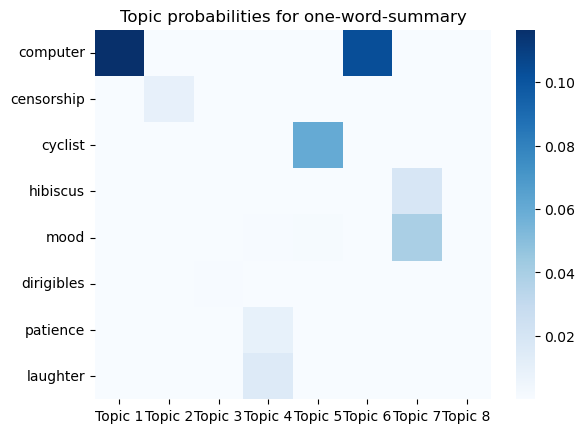

In [34]:
one_word = list(topic_dict['topic'].values())
sns.heatmap(topics.reindex(one_word), cmap='Blues')
plt.title('Topic probabilities for one-word-summary')
plt.show()

The heatmap suggests assignments for all but 1 topics. 

Below are the most probable words for each topic. We can already see our one-word summaries of the actual topic near the top of the list. 

In [35]:
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(10).index.tolist()
pd.DataFrame(top_words)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,computer,book,building,laugh,cyclist,computer,mood,caps3
1,spend,library,dirigible,patient,water,help,love,caps4
2,exercise,read,obstacle,wait,setting,learn,paragraph,caps5
3,kid,offensive,empire,laughter,affect,talk,memoir,caps6
4,outside,child,mast,mom,feature,online,test,person1
5,bad,movie,builder,tell,road,information,sang,person2
6,nature,shelf,face,start,hill,place,hibiscus,caps7
7,play,music,dock,patience,desert,hand,narcissa,organization1
8,reason,material,mooring,person1,hot,reason,create,caps8
9,enjoy,magazine,wind,hour,ride,internet,grateful,caps9


Now we can assign LDA topic probabilities to each essay and aggregate. It is now clear that, for example, LDA allocated topic 3 is aligned with the given topic "computers".

In [36]:
train_preds = lda_base.transform(doc_term_matrix)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=training_set.topic)
train_eval.sample(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
topic,,,,,,,,
censorship,0.001192,0.991660,0.001191,0.001192,0.001191,0.001192,0.001191,0.001191
laughter,0.000596,0.043366,0.000597,0.764957,0.000596,0.051134,0.075495,0.063259
mood,0.006258,0.006254,0.006251,0.006257,0.006253,0.006263,0.956209,0.006254
dirigibles,0.001406,0.001405,0.990163,0.001405,0.001405,0.001405,0.001406,0.001405
censorship,0.001017,0.992883,0.001017,0.001017,0.001017,0.001017,0.001017,0.001016
hibiscus,0.003382,0.003381,0.003380,0.003387,0.041978,0.003380,0.937727,0.003385
laughter,0.076853,0.001391,0.001389,0.794300,0.001390,0.001392,0.001390,0.121895
dirigibles,0.007821,0.007817,0.656216,0.007823,0.007814,0.296871,0.007814,0.007823
censorship,0.002018,0.985875,0.002017,0.002018,0.002017,0.002020,0.002018,0.002017


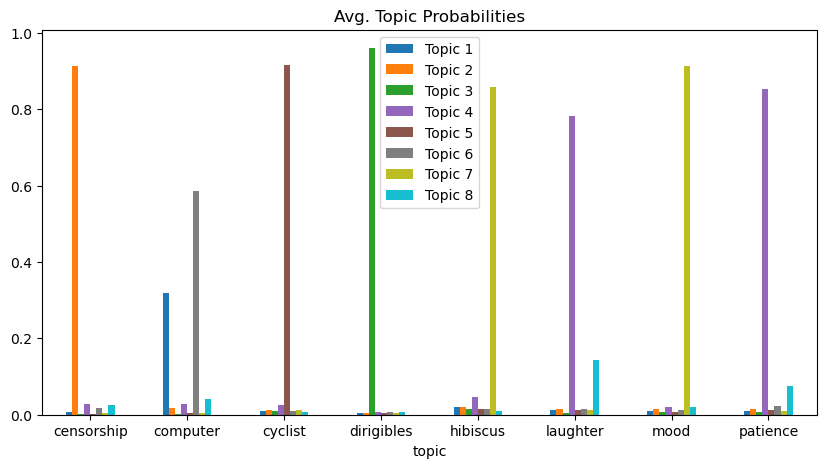

In [37]:
train_eval.groupby(level='topic').mean().plot.bar(title='Avg. Topic Probabilities', rot=0, colormap='tab10', figsize=(10,5));

The baseline model was successful in that each given topic is allocated with high probability to an LDA topic:

,topic,assignment
0,censorship,Topic 2
1,computer,Topic 6
2,cyclist,Topic 5
3,dirigibles,Topic 3
4,hibiscus,Topic 7
5,laughter,Topic 4
6,mood,Topic 7
7,patience,Topic 4


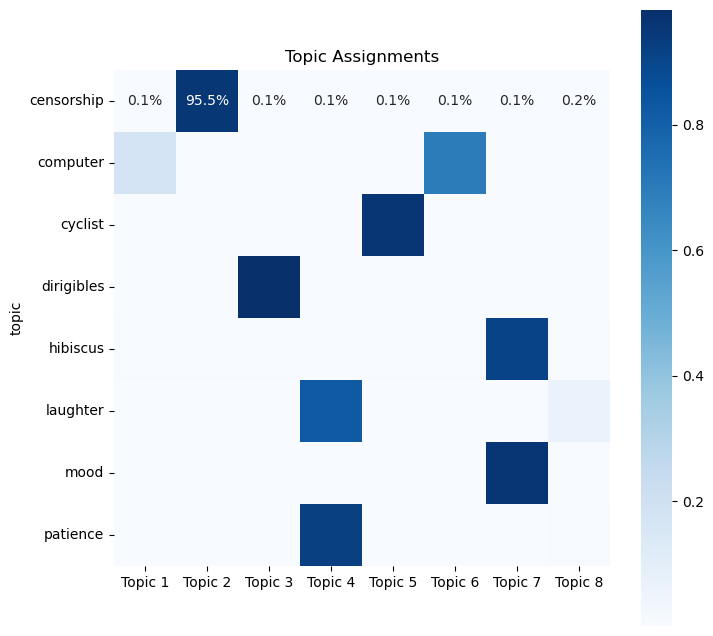

In [38]:
df = train_eval.groupby(level='topic').agg('median')
fig, ax = plt.subplots(figsize=(8,8))
g = sns.heatmap(df, annot=True, fmt='.1%', annot_kws={"size": 10}, cmap='Blues', square=True)
loc, labels = plt.yticks()
g.set_yticklabels(labels, rotation=0)
g.set_title('Topic Assignments');

df = train_eval\
            .idxmax(axis=1)\
            .reset_index()\
            .groupby('topic', as_index=False)\
            .agg(lambda x:x.value_counts().index[0])\
            .rename(columns={0:'assignment'})
df

## Visualization with PyLDAVis

In [39]:
prepare(lda_base, doc_term_matrix, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.090295 -0.123216       1        1  21.725307
3     -0.086287  0.082825       2        1  18.595515
5     -0.112535 -0.171678       3        1  14.624098
2      0.377422 -0.075198       4        1  12.617314
6     -0.024620  0.092734       5        1  12.106779
4      0.093849  0.136312       6        1   7.491754
0     -0.076472 -0.154230       7        1   7.463529
7     -0.081061  0.212452       8        1   5.375703, topic_info=           Term          Freq         Total Category  logprob  loglift
359    computer  20485.000000  20485.000000  Default  30.0000  30.0000
200        book  13946.000000  13946.000000  Default  29.0000  29.0000
227    building   7806.000000   7806.000000  Default  28.0000  28.0000
521   dirigible   6226.000000   6226.000000  Default  27.0000  27.0000
264       caps3   4623.000000   4623.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1097        man    194.233654   1020.401911   Topic8  -5.4741   1.2644
1077       love    245.900320   3858.017303   Topic8  -5.2383   0.1703
1705      start    230.477156   3678.648099   Topic8  -5.3030   0.1531
1991       year    202.406428   1952.968015   Topic8  -5.4329   0.6565
670        face    198.792031   3483.921222   Topic8  -5.4509   0.0596

[516 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3         4  0.037657  abandon
3         6  0.941432  abandon
3         7  0.008368  abandon
3         8  0.012552  abandon
4         1  0.990023    abhor
...     ...       ...      ...
1996      3  0.034455    young
1996      5  0.059453    young
1996      6  0.024997    young
1996      7  0.054723    young
1996      8  0.035807    young

[1348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 6, 3, 7, 5, 1, 8])

### "Score Allocation"

Can we take this to the next level and assign target scores based on word probabilities? To keep it simple, we'll limit the essays to topic number 4, "hibiscus". This topic has only four target scores and a reasonably balanced distribution.

In [40]:
hibiscus = training_set[training_set.topic == 'hibiscus']

# Split essays into training and test sets
train_essays, test_essays = train_test_split(hibiscus, 
                                         stratify=hibiscus.target_score, 
                                         test_size=0.2, 
                                         random_state=42)

In [42]:
vectorizer = CountVectorizer(max_df=.2, 
                             min_df=3, 
                             stop_words=list(STOP_WORDS), 
                             max_features=400) # limit to account for smaller set of essays

# Train and test doc-term matrices
train_dtm = vectorizer.fit_transform(train_essays.l_essay)
test_dtm = vectorizer.fit_transform(test_essays.l_essay)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [43]:
lda_score = LatentDirichletAllocation(n_components=4,
                                     n_jobs=-1,
                                     learning_method='batch',
                                     evaluate_every=5,
                                     verbose=1, 
                                     max_iter=500)
lda_score.fit(train_dtm)

# save training model
joblib.dump(lda_score, 'lda_score.pkl')

iteration: 1 of max_iter: 500
iteration: 2 of max_iter: 500
iteration: 3 of max_iter: 500
iteration: 4 of max_iter: 500
iteration: 5 of max_iter: 500, perplexity: 284.7708
iteration: 6 of max_iter: 500
iteration: 7 of max_iter: 500
iteration: 8 of max_iter: 500
iteration: 9 of max_iter: 500
iteration: 10 of max_iter: 500, perplexity: 276.5026
iteration: 11 of max_iter: 500
iteration: 12 of max_iter: 500
iteration: 13 of max_iter: 500
iteration: 14 of max_iter: 500
iteration: 15 of max_iter: 500, perplexity: 273.2062
iteration: 16 of max_iter: 500
iteration: 17 of max_iter: 500
iteration: 18 of max_iter: 500
iteration: 19 of max_iter: 500
iteration: 20 of max_iter: 500, perplexity: 271.5828
iteration: 21 of max_iter: 500
iteration: 22 of max_iter: 500
iteration: 23 of max_iter: 500
iteration: 24 of max_iter: 500
iteration: 25 of max_iter: 500, perplexity: 270.6663
iteration: 26 of max_iter: 500
iteration: 27 of max_iter: 500
iteration: 28 of max_iter: 500
iteration: 29 of max_iter: 500


['lda_score.pkl']

In [44]:
topic_labels = ['Score A', 'Score B', 'Score C', 'Score D'] #.format(i) for i in range(1, 5)]

train_preds = lda_score.transform(train_dtm)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_essays.target_score)
train_eval.sample(5)

,Score A,Score B,Score C,Score D
target_score,,,,
1,0.013395,0.193333,0.683054,0.110218
2,0.032944,0.033714,0.900212,0.033131
0,0.250000,0.250000,0.250000,0.250000
1,0.494167,0.047301,0.042709,0.415824
1,0.364097,0.028443,0.029704,0.577757


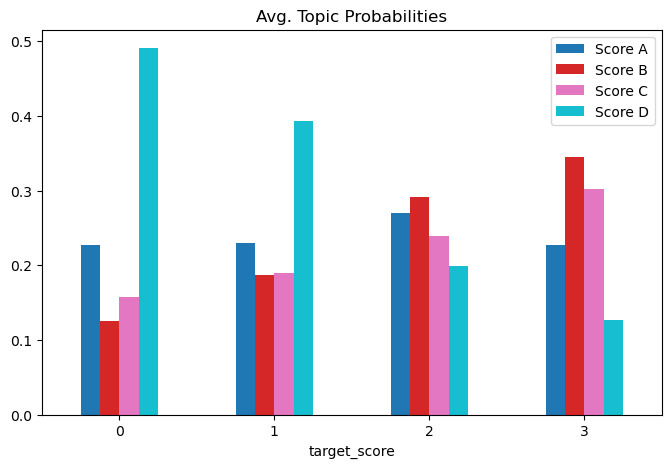

In [45]:
train_eval.groupby(level='target_score')\
            .mean()\
            .plot\
            .bar(title='Avg. Topic Probabilities', rot=0, colormap='tab10', figsize=(8,5));

,target_score,assignment
0,0,Score D
1,1,Score D
2,2,Score B
3,3,Score B


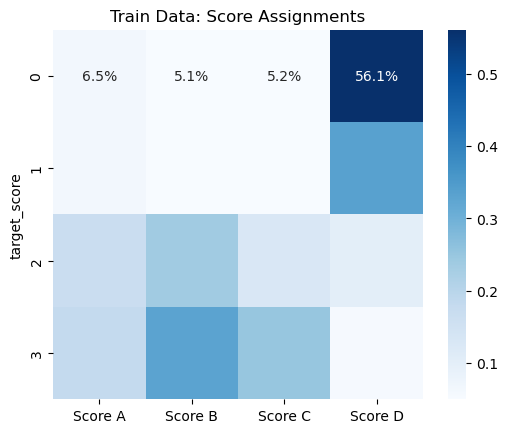

In [46]:
df = train_eval.groupby(level='target_score').agg('median')
sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Train Data: Score Assignments');

df = train_eval\
            .idxmax(axis=1)\
            .reset_index()\
            .groupby('target_score', as_index=False)\
            .agg(lambda x:x.value_counts().index[0])\
            .rename(columns={0:'assignment'})
df

In [47]:
test_preds = lda_score.transform(test_dtm)
test_eval = pd.DataFrame(test_preds, columns=topic_labels, index=test_essays.target_score)
test_eval.head()

,Score A,Score B,Score C,Score D
target_score,,,,
2,0.269809,0.256387,0.398377,0.075428
3,0.131576,0.298208,0.217197,0.353020
0,0.375829,0.037287,0.419204,0.167680
1,0.465458,0.231958,0.217381,0.085203
1,0.914477,0.028287,0.028804,0.028433


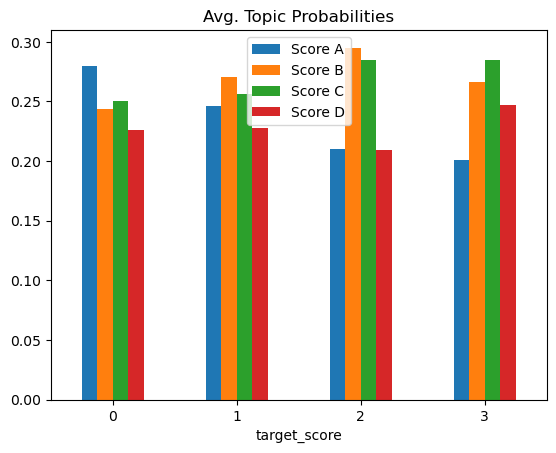

In [48]:
test_eval.groupby(level='target_score')\
            .mean()\
            .plot\
            .bar(title='Avg. Topic Probabilities', rot=0);

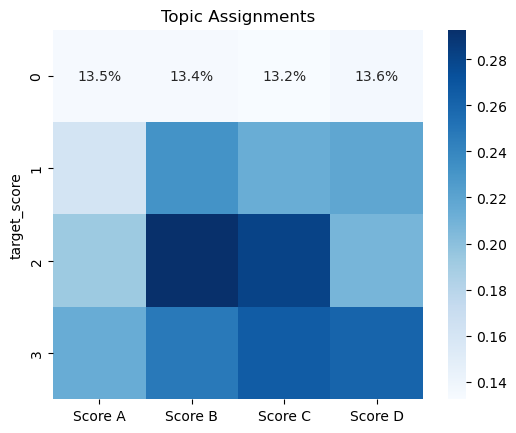

In [49]:
df = test_eval.groupby(level='target_score').agg('median')
sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Topic Assignments')
plt.show()

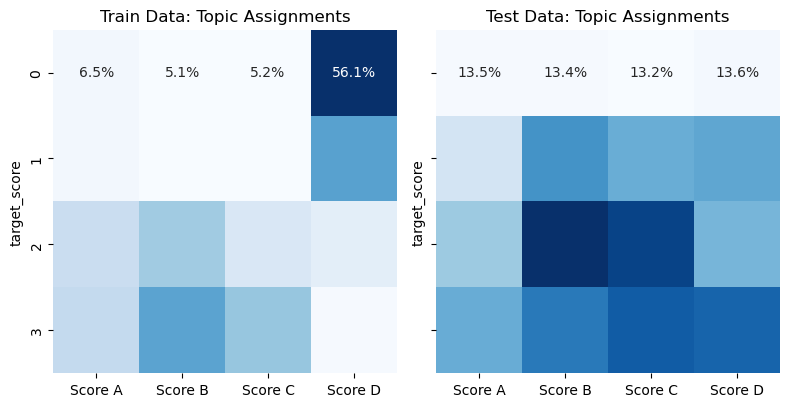

In [50]:
fig, axes = plt.subplots(ncols=2, figsize=(8,6), sharey=True)
source = ['Train', 'Test']
for i, df in enumerate([train_eval, test_eval]):
    df = df.groupby(level='target_score').agg('median')
    sns.heatmap(df, annot=True, fmt='.1%', cmap='Blues', square=True, ax=axes[i], cbar=False)
    axes[i].set_title('{} Data: Topic Assignments'.format(source[i]))
plt.tight_layout()
plt.show()

While the charts above are very similar to a confusion matrix, the ordering of the LDA derived topics (A,B,C,D) doesn't necessarily match the human-labeled topic ordering (0,1,2,3). Thus, the high percentages, shown here as deep blues, are not expected to be found along the diagonal. Instead the goal is to find topic distinction, indicated by a single dark square in each column, and model accuracy, indicated by identical color patterns between train and test data sets.

As seen above, there is some agreement between train and test data that essays with highest and lowest scores are distinct and assigned "Score A" and "Score B" respectively.  Overall, both topic distinction and model accuracy are rather poor. It is highly improbable this approach could be extended to any of the other topics due to the larger range of scores and class imbalance. 

Furthermore, repeated LDA runs show a lack of reproducability, which is a sign of poor distinction of topics. In summary, topic modelling, or more specifically using word frequencies and probabilities is not a useful tool to grade student essays. In the next notebook we'll continue with machine learning algorithms.